In [85]:
from src.plots_generation.analysis_utils import get_gae_embeddings
from src.baselines.embeddings import get_bert_models, VectorizerProcessor
import pandas as pd
from config import BASE_DIR, get_paths_by_domain

DOMAIN = "bible"
paths = get_paths_by_domain("bible")
df_path = paths["data_csv_path"]
df = pd.read_csv(df_path)
vectorizers = get_bert_models(DOMAIN) + ["trigram", "tfidf"]
processor = VectorizerProcessor(
    df, paths["processed_vectorizers_path"], vectorizers
)
processed_vectorizers = processor.load_or_generate_embeddings()

bert_model = "dicta-il/BEREL"
model_file = "trained_gae_model_bible_BEREL.pth"
param_dict = {
    "num_adjs": 2,
    "epochs": 50,
    "hidden_dim": 300,
    "distance": "cosine",
    "learning_rate": 0.0001,
    "threshold": 0.99,
    "adjacencies": [
        {"type": "tfidf", "params": {"max_features": 10000, "min_df": 0.01}},
        {
            "type": "trigram",
            "params": {
                "analyzer": "char",
                "ngram_range": (3, 3),
                "min_df": 0.01,
                "max_features": 10000,
            },
        },
    ],
}

gae_embeddings = get_gae_embeddings(
    df, processed_vectorizers, bert_model, model_file, param_dict
)

Loaded the embeddings: ['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'dicta-il/MsBERT', 'tfidf', 'trigram']
Loaded the following embeddings dict_keys(['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'dicta-il/MsBERT', 'tfidf', 'trigram'])


/Users/yonatanlou/dev/QumranNLP/src/gnn/adjacency.py:170: RuntimeWarning:

divide by zero encountered in power



2025-01-26 07:55:06.863072 - tfidf n edges before filtering: 21146477, n edges after filtering: 219961
2025-01-26 07:55:12.493515 - trigram n edges before filtering: 21987580, n edges after filtering: 219962


In [86]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.metrics.pairwise import cosine_similarity

def remove_outliers(df,gae_embeddings, outlier_threshold = 2):
    
    # Ensure groupby_col is defined
    groupby_col = "book"  # Adjust to match the appropriate column name
    unique_books = df.dropna(subset=["book"], axis=0)[groupby_col].unique()
    
    new_embeddings = []
    new_df = pd.DataFrame()
    
    for book in unique_books:
        # Get the embeddings for the current book
        book_mask = df["book"] == book
        book_indices = np.where(book_mask)[0]
        book_embeddings = gae_embeddings[book_indices]
    
        # Compute the initial average embedding
        avg_embedding = np.mean(book_embeddings, axis=0, keepdims=True)
    
        # Calculate cosine similarities of each embedding to the average
        similarities = cosine_similarity(book_embeddings, avg_embedding).flatten()
    
        # Compute Z-scores for the cosine similarities
        similarity_z_scores = zscore(similarities)
    
        # Filter out embeddings with Z-scores above the threshold
        valid_indices = np.abs(similarity_z_scores) <= outlier_threshold
        valid_embeddings = book_embeddings[valid_indices]
    
        # Append valid embeddings to the list
        new_embeddings.extend(valid_embeddings)
    
        # Append valid rows to new_df
        valid_df_rows = df.loc[book_mask].iloc[valid_indices]
        new_df = pd.concat([new_df, valid_df_rows], ignore_index=True)
    
        print(
            "Removed",
            book_indices.shape[0] - valid_embeddings.shape[0],
            "outliers out of",
            book_indices.shape[0],
        )
    
    # Convert the new embeddings list to a numpy array for consistency
    new_gae_embeddings = np.array(new_embeddings)
    return new_df, new_gae_embeddings



In [87]:
new_df, new_gae_embeddings = remove_outliers(df,gae_embeddings, outlier_threshold = 2)

Removed 13 outliers out of 171
Removed 15 outliers out of 205
Removed 14 outliers out of 208
Removed 15 outliers out of 217
Removed 8 outliers out of 191
Removed 9 outliers out of 172
Removed 2 outliers out of 31
Removed 4 outliers out of 90
Removed 14 outliers out of 221
Removed 3 outliers out of 47
Removed 5 outliers out of 51
Removed 9 outliers out of 260
Removed 5 outliers out of 287
Removed 4 outliers out of 58
Removed 14 outliers out of 317
Removed 0 outliers out of 10
Removed 1 outliers out of 10
Removed 1 outliers out of 35
Removed 14 outliers out of 251
Removed 11 outliers out of 326
Removed 11 outliers out of 120
Removed 0 outliers out of 15
Removed 0 outliers out of 11
Removed 8 outliers out of 159
Removed 8 outliers out of 155
Removed 1 outliers out of 22
Removed 14 outliers out of 187
Removed 1 outliers out of 13
Removed 0 outliers out of 21
Removed 1 outliers out of 9
Removed 6 outliers out of 86
Removed 8 outliers out of 254
Removed 0 outliers out of 5
Removed 3 outliers

In [88]:
import umap
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.manifold import TSNE

def plot_embeddings_projection(embeddings, df, method='umap', random_state=42, save_path=None):
    """
    Create an interactive visualization of embeddings using either UMAP or t-SNE.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        The embedding vectors
    df : pandas.DataFrame
        DataFrame containing a 'book' column
    method : str
        Dimensionality reduction method ('umap' or 'tsne')
    random_state : int
        Random seed for reproducibility
    save_path : str, optional
        If provided, saves the plot to this path as an HTML file
    
    Returns:
    --------
    plotly.graph_objects.Figure
        Interactive Plotly figure
    """
    # Parameters for dimensionality reduction
    n_components = 2
    
    # Choose and apply dimensionality reduction method
    if method.lower() == 'umap':
        reducer = umap.UMAP(
            random_state=random_state,
            n_neighbors=15,
            min_dist=0.1,
            n_components=n_components,
            metric="cosine"
        )
        reduced_embeddings = reducer.fit_transform(embeddings)
        method_name = 'UMAP'
    
    elif method.lower() == 'tsne':
        reducer = TSNE(
            n_components=n_components,
            random_state=random_state,
            init='pca',  # Initialize with PCA for better results
            learning_rate='auto',
            perplexity=30,
            metric='cosine'
        )
        reduced_embeddings = reducer.fit_transform(embeddings)
        method_name = 't-SNE'
    
    else:
        raise ValueError("Method must be either 'umap' or 'tsne'")
    
    # Create a DataFrame with the reduced coordinates and book labels
    plot_df = pd.DataFrame({
        'Dim1': reduced_embeddings[:, 0],
        'Dim2': reduced_embeddings[:, 1],
        'Book': df['book'],
        'Text': df['text']  # Including text for hover information
    })
    
    # Create the interactive plot
    fig = px.scatter(
        plot_df,
        x='Dim1',
        y='Dim2',
        color='Book',
        color_discrete_sequence=px.colors.qualitative.Set3,
        hover_data={
            'Dim1': False,  # Hide Dim1 in hover tooltip
            'Dim2': False,  # Hide Dim2 in hover tooltip
            'Text': False,   # Show text in hover tooltip
            'Book': True    # Show book in hover tooltip
        },
        title=f'{method_name} Visualization of Book Embeddings'
    )
    
    # Update layout for better visualization
    fig.update_layout(
        width=1000,
        height=800,
        title={
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 20}
        },
        legend={
            'title': 'Books',
            'yanchor': 'top',
            'y': 0.99,
            'xanchor': 'left',
            'x': 1.02,
            'bgcolor': 'rgba(255, 255, 255, 0.8)'
        },
        xaxis_title=f'{method_name} Dimension 1',
        yaxis_title=f'{method_name} Dimension 2',
        hovermode='closest'
    )
    
    # Update traces
    fig.update_traces(
        marker=dict(size=6),
        opacity=0.7
    )
    
    # Save to HTML if path is provided
    if save_path:
        fig.write_html(save_path)
    
    return fig








In [99]:

# fig = plot_embeddings_projection(new_gae_embeddings, new_df, method='tsne', random_state=42)
# fig.write_html("/Users/yonatanlou/dev/QumranNLP/reports/plots/bible/bible_scatter_plot.html")
# fig.show()


In [98]:

# fig = plot_embeddings_projection(new_gae_embeddings, new_df, method='tsne', random_state=42)
# fig.write_html("/Users/yonatanlou/dev/QumranNLP/reports/plots/bible/bible_scatter_plot.html")
# fig.show()


/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



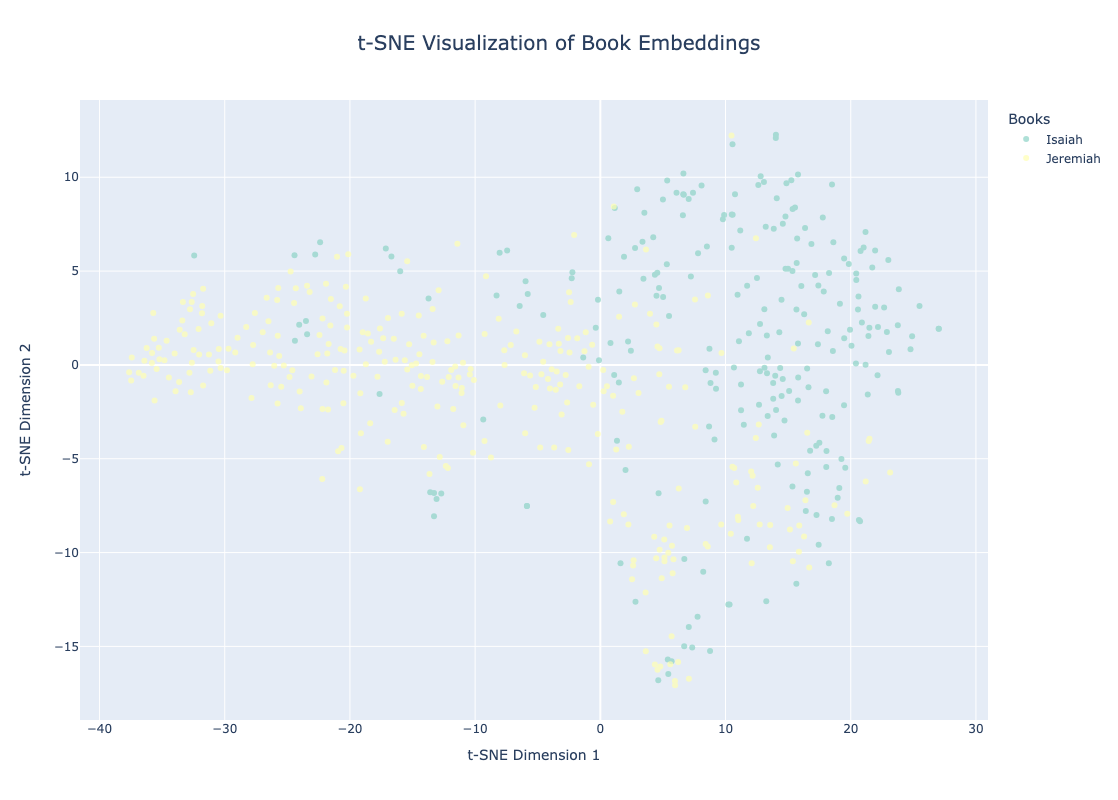

In [59]:
books_to_plot = ["Jeremiah", 'Isaiah']
# books_to_plot = ['2_Samuel', 'Daniel', 'Deuteronomy', 'Esther', 'Exodus', 'Ezra', 'Isaiah', 'Jeremiah', 'Job', 'Jonah', 'Joshua', 'Proverbs', 'Psalms', 'Song_of_songs']

idxs = new_df[new_df["book"].isin(books_to_plot)].index


fig = plot_embeddings_projection(new_gae_embeddings[idxs], new_df.loc[idxs], "tsne")
fig.show()  # This will open the interactive plot in your browser

## Dss

In [1]:
from src.plots_generation.analysis_utils import get_gae_embeddings
from src.baselines.embeddings import get_bert_models, VectorizerProcessor
import pandas as pd
from config import BASE_DIR, get_paths_by_domain

DOMAIN = "dss"
paths = get_paths_by_domain(DOMAIN)
df_path = paths["data_csv_path"]
df = pd.read_csv(df_path)
vectorizers = get_bert_models(DOMAIN) + ["trigram", "tfidf"]
processor = VectorizerProcessor(
    df, paths["processed_vectorizers_path"], vectorizers
)
processed_vectorizers = processor.load_or_generate_embeddings()

bert_model = "dicta-il/BEREL"
model_file = "trained_gae_model_BEREL.pth"
param_dict = {
    "num_adjs": 2,
    "epochs": 50,
    "hidden_dim": 300,
    "distance": "cosine",
    "learning_rate": 0.001,
    "threshold": 0.98,
    "adjacencies": [
        {"type": "tfidf", "params": {"max_features": 10000, "min_df": 0.01}},
        {
            "type": "trigram",
            "params": {
                "analyzer": "char",
                "ngram_range": (3, 3),
                "min_df": 0.01,
                "max_features": 10000,
            },
        },
    ],
}
df_no_nulls = df
df_no_nulls["section"] = df_no_nulls["section"].fillna("unknown")
df_no_nulls = df_no_nulls[
    ~(df_no_nulls["composition"].isin(["4QH", "4QM", "4QS", "4QD"]))
]
noisy_compositions = [
        "Para_Gen-Exod", "Beatitudes",
    ]
df_no_nulls = df_no_nulls[
    ~(df_no_nulls["composition"].isin(noisy_compositions))
]
gae_embeddings = get_gae_embeddings(
    df_no_nulls, processed_vectorizers, bert_model, model_file, param_dict
)

Loaded the embeddings: ['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'yonatanlou/BEREL-finetuned-DSS-maskedLM', 'tfidf', 'trigram', 'starr', 'yonatanlou/alephbert-base-finetuned-DSS-maskedLM', 'yonatanlou/dictabert-finetuned-DSS-maskedLM', 'dicta-il/MsBERT']
Loaded the following embeddings dict_keys(['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'yonatanlou/BEREL-finetuned-DSS-maskedLM', 'tfidf', 'trigram', 'starr', 'yonatanlou/alephbert-base-finetuned-DSS-maskedLM', 'yonatanlou/dictabert-finetuned-DSS-maskedLM', 'dicta-il/MsBERT'])
2025-03-13 21:06:06.985993 - tfidf n edges before filtering: 744482, n edges after filtering: 16782
2025-03-13 21:06:07.403233 - trigram n edges before filtering: 839056, n edges after filtering: 16782


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.metrics.pairwise import cosine_similarity

def remove_outliers(df,gae_embeddings, outlier_threshold = 2):
    
    # Ensure groupby_col is defined
    groupby_col = "composition"  # Adjust to match the appropriate column name
    unique_books = df.dropna(subset=[groupby_col], axis=0)[groupby_col].unique()
    
    new_embeddings = []
    new_df = pd.DataFrame()
    
    for book in unique_books:
        # Get the embeddings for the current book
        book_mask = df[groupby_col] == book
        book_indices = np.where(book_mask)[0]
        book_embeddings = gae_embeddings[book_indices]
    
        # Compute the initial average embedding
        avg_embedding = np.mean(book_embeddings, axis=0, keepdims=True)
    
        # Calculate cosine similarities of each embedding to the average
        similarities = cosine_similarity(book_embeddings, avg_embedding).flatten()
    
        # Compute Z-scores for the cosine similarities
        similarity_z_scores = zscore(similarities)
    
        # Filter out embeddings with Z-scores above the threshold
        valid_indices = np.abs(similarity_z_scores) <= outlier_threshold
        valid_embeddings = book_embeddings[valid_indices]
    
        # Append valid embeddings to the list
        new_embeddings.extend(valid_embeddings)
    
        # Append valid rows to new_df
        valid_df_rows = df.loc[book_mask].iloc[valid_indices]
        new_df = pd.concat([new_df, valid_df_rows], ignore_index=True)
    
        print(
            "Removed",
            book_indices.shape[0] - valid_embeddings.shape[0],
            "outliers out of",
            book_indices.shape[0],
        )
    
    # Convert the new embeddings list to a numpy array for consistency
    new_gae_embeddings = np.array(new_embeddings)
    return new_df, new_gae_embeddings



In [3]:
new_df, new_gae_embeddings = remove_outliers(df_no_nulls,gae_embeddings, outlier_threshold = 2)


Removed 2 outliers out of 46
Removed 1 outliers out of 42
Removed 1 outliers out of 7
Removed 0 outliers out of 6
Removed 2 outliers out of 45
Removed 3 outliers out of 49
Removed 5 outliers out of 82
Removed 1 outliers out of 6
Removed 1 outliers out of 10
Removed 3 outliers out of 85
Removed 1 outliers out of 13
Removed 1 outliers out of 7
Removed 0 outliers out of 4
Removed 2 outliers out of 50
Removed 0 outliers out of 3
Removed 1 outliers out of 43
Removed 0 outliers out of 11
Removed 0 outliers out of 14
Removed 0 outliers out of 9
Removed 1 outliers out of 10
Removed 0 outliers out of 5
Removed 2 outliers out of 17
Removed 1 outliers out of 39
Removed 4 outliers out of 61
Removed 0 outliers out of 4
Removed 0 outliers out of 15
Removed 2 outliers out of 19
Removed 1 outliers out of 13
Removed 1 outliers out of 15
Removed 1 outliers out of 18
Removed 1 outliers out of 11
Removed 0 outliers out of 5
Removed 3 outliers out of 132
Removed 0 outliers out of 5
Removed 0 outliers out o

In [4]:
import umap
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.manifold import TSNE

def new_line_each_n_words(txt):
    new_text = ""
    splitted = txt.split(" ")
    word_counter = 0
    for w in splitted:
        new_text += f"{w} "
        if word_counter >20:
            new_text+="<br>"
            word_counter = 0
        word_counter +=1
    return new_text
        

def plot_embeddings_projection(embeddings, df_origin, method='umap', color_by="Section", random_state=42, save_path=None):
    # Parameters for dimensionality reduction
    n_components = 2
    df = df_origin.copy()
    df["text"] = df["text"].apply(new_line_each_n_words)

    # Choose and apply dimensionality reduction method
    if method.lower() == 'umap':
        reducer = umap.UMAP(
            random_state=random_state,
            n_neighbors=15,
            min_dist=0.1,
            n_components=n_components,
            metric="cosine"
        )
        reduced_embeddings = reducer.fit_transform(embeddings)
        method_name = 'UMAP'
    
    elif method.lower() == 'tsne':
        reducer = TSNE(
            n_components=n_components,
            random_state=random_state,
            init='pca',  # Initialize with PCA for better results
            learning_rate='auto',
            perplexity=30,
            metric='cosine'
        )
        reduced_embeddings = reducer.fit_transform(embeddings)
        method_name = 't-SNE'
    
    else:
        raise ValueError("Method must be either 'umap' or 'tsne'")
    
    # Create a DataFrame with the reduced coordinates and book labels
    plot_df = pd.DataFrame({
        'Dim1': reduced_embeddings[:, 0],
        'Dim2': reduced_embeddings[:, 1],
        'Composition': df['composition'],
        'Section': df["section"],
        'Text': df['text'],  # Including text for hover information
        'Chunk path': df["sentence_path"]
    })
    # Create the interactive plot
    fig = px.scatter(
        plot_df,
        x='Dim1',
        y='Dim2',
        color=color_by,
        color_discrete_sequence=px.colors.qualitative.Set3,
        hover_data={
            'Dim1': False,  # Hide Dim1 in hover tooltip
            'Dim2': False,  # Hide Dim2 in hover tooltip
            'Text': False,   # Show text in hover tooltip
            'Composition': True,    # Show book in hover tooltip
            'Section': True,
            'Chunk path': True
        },
        title=f"{method_name} Visualization of {color_by.replace('Section', 'Sectarian')} Embeddings"
    )
    
    # Update layout for better visualization
    fig.update_layout(
        width=1000,
        height=800,
        title={
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 20}
        },
        legend={
            'title': 'Books',
            'yanchor': 'top',
            'y': 0.99,
            'xanchor': 'left',
            'x': 1.02,
            'bgcolor': 'rgba(255, 255, 255, 0.8)'
        },
        xaxis_title=f'{method_name} Dimension 1',
        yaxis_title=f'{method_name} Dimension 2',
        hovermode='closest'
    )
    
    # Update traces
    fig.update_traces(
        marker=dict(size=6),
        opacity=0.7
    )
    
    # Save to HTML if path is provided
    if save_path:
        fig.write_html(save_path)
    
    return fig








In [5]:
from plotly.io import write_html

# Create the two figures
fig1 = plot_embeddings_projection(new_gae_embeddings, new_df, color_by="Section", method='tsne', random_state=42)
fig2 = plot_embeddings_projection(new_gae_embeddings, new_df, color_by="Composition", method='tsne', random_state=42)

# Enhanced HTML template with styling
html_str = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Dead sea scrolls unsupervised clustering</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.0.0/css/all.min.css">
    <style>
        /* Modern clean styling */
        :root {{
            --primary-color: #3498db;
            --secondary-color: #2c3e50;
            --background-color: #f8f9fa;
            --card-color: #ffffff;
            --text-color: #333333;
            --border-radius: 8px;
            --box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        }}
        
        body {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            margin: 0;
            padding: 0;
            background-color: var(--background-color);
            color: var(--text-color);
            line-height: 1.6;
        }}
        
        header {{
            background-color: var(--secondary-color);
            color: white;
            padding: 1.5rem 2rem;
            box-shadow: var(--box-shadow);
            text-align: center;
        }}
        
        main {{
            max-width: 1200px;
            margin: 0 auto;
            padding: 2rem;
        }}
        
        h1 {{
            margin: 0;
            font-size: 2.2rem;
            text-align: center;
        }}
        
        .subtitle {{
            opacity: 0.8;
            margin-top: 0.5rem;
            text-align: center;
        }}
        
        .abstract {{
            background-color: var(--card-color);
            border-radius: var(--border-radius);
            box-shadow: var(--box-shadow);
            padding: 1.5rem 2rem;
            margin-bottom: 2rem;
            text-align: center;
            line-height: 1.7;
        }}
        
        .abstract h2 {{
            color: var(--secondary-color);
            margin-top: 0;
            font-size: 1.4rem;
            text-align: center;
        }}
        
        .abstract p {{
            margin-bottom: 0.7rem;
        }}
        
        .plot-container {{
            background-color: var(--card-color);
            border-radius: var(--border-radius);
            box-shadow: var(--box-shadow);
            margin-bottom: 2rem;
            overflow: hidden;
        }}
        
        .plot-header {{
            padding: 1rem 1.5rem;
            border-bottom: 1px solid #eee;
            display: flex;
            justify-content: space-between;
            align-items: center;
        }}
        
        .plot-header h2 {{
            margin: 0;
            color: var(--secondary-color);
            font-size: 1.5rem;
            text-align: center;
            flex-grow: 1;
        }}
        
        .plot-description {{
            padding: 0 1.5rem;
            color: #666;
            font-size: 0.95rem;
            text-align: center;
        }}
        
        .plot-content {{
            padding: 1rem;
            display: flex;
            justify-content: center;
        }}
        
        footer {{
            text-align: center;
            padding: 1.5rem;
            background-color: var(--secondary-color);
            color: white;
            font-size: 0.9rem;
        }}
        
        .controls {{
            display: flex;
            gap: 0.5rem;
        }}
        
        .controls button {{
            background-color: transparent;
            border: none;
            cursor: pointer;
            color: var(--primary-color);
            font-size: 1.2rem;
            width: 36px;
            height: 36px;
            border-radius: 50%;
            display: flex;
            align-items: center;
            justify-content: center;
            transition: background-color 0.2s;
        }}
        
        .controls button:hover {{
            background-color: rgba(0, 0, 0, 0.05);
        }}
        
        /* Responsive design */
        @media (max-width: 768px) {{
            main {{
                padding: 1rem;
            }}
            
            .abstract {{
                padding: 1rem;
            }}
        }}
    </style>
</head>
<body>
    <header>
        <h1>Dead sea scrolls unsupervised clustering</h1>
        <div class="subtitle">Integrating Semantic and Statistical Features for Authorial Clustering of Qumran Scrolls</div>
    </header>
    
    <main>
        <div class="abstract">
            <h2>Abstract</h2>
            <p>We present a novel framework for authorial classification and clustering of the Qumran Dead Sea Scrolls (DSS). Our approach combines modern Hebrew BERT embeddings with traditional natural language processing features in a graph neural network (GNN) architecture.</p>
            <p>Our results outperform baseline methods on both the Dead Sea Scrolls and a validation dataset of the Hebrew Bible. In particular, we leverage our model to provide significant insights into long-standing debates, including the classification of sectarian and non-sectarian texts and the division of the Hodayot collection of hymns.</p>
        </div>
        
        <div class="plot-container">
            <div class="plot-header">
                <div class="controls">
                    <button title="Download as PNG" onclick="downloadPlot('figure1')">
                        <i class="fas fa-download"></i>
                    </button>
                    <button title="Fullscreen" onclick="toggleFullscreen('plot-content-1')">
                        <i class="fas fa-expand"></i>
                    </button>
                </div>
                <h2>Clustering by sectarian/non-sectarian</h2>
                <div style="width: 92px;"></div>
            </div>
            <div class="plot-description">
                <p>The colors in this visualization shows the distribution of text clusters across sectarian and non-sectarian.</p>
            </div>
            <div id="plot-content-1" class="plot-content">
                {fig1.to_html(full_html=False, include_plotlyjs=False, div_id="figure1")}
            </div>
        </div>
        
        <div class="plot-container">
            <div class="plot-header">
                <div class="controls">
                    <button title="Download as PNG" onclick="downloadPlot('figure2')">
                        <i class="fas fa-download"></i>
                    </button>
                    <button title="Fullscreen" onclick="toggleFullscreen('plot-content-2')">
                        <i class="fas fa-expand"></i>
                    </button>
                </div>
                <h2>Clustering by Composition</h2>
                <div style="width: 92px;"></div>
            </div>
            <div class="plot-description">
                <p>The colors in this visualization shows the distribution of text clusters across different compositions.</p>
            </div>
            <div id="plot-content-2" class="plot-content">
                {fig2.to_html(full_html=False, include_plotlyjs=False, div_id="figure2")}
            </div>
        </div>
    </main>
    
    <footer>
        <p>© 2025 2025 Roded Sharan Lab | Created with Plotly.js</p>
    </footer>
    
    <script>
        // Utility functions for download and fullscreen
        function downloadPlot(plotId) {{
            Plotly.downloadImage(
                document.getElementById(plotId), 
                {{format: 'png', width: 1200, height: 800, filename: 'dss-plot-' + plotId}}
            );
        }}
        
        function toggleFullscreen(elementId) {{
            const element = document.getElementById(elementId);
            
            if (!document.fullscreenElement) {{
                if (element.requestFullscreen) {{
                    element.requestFullscreen();
                }} else if (element.webkitRequestFullscreen) {{
                    element.webkitRequestFullscreen();
                }} else if (element.msRequestFullscreen) {{
                    element.msRequestFullscreen();
                }}
            }} else {{
                if (document.exitFullscreen) {{
                    document.exitFullscreen();
                }} else if (document.webkitExitFullscreen) {{
                    document.webkitExitFullscreen();
                }} else if (document.msExitFullscreen) {{
                    document.msExitFullscreen();
                }}
            }}
        }}
    </script>
</body>
</html>
"""

# Write the combined HTML to a file
output_path = "/Users/yonatanlou/dev/QumranNLP/index.html"
with open(output_path, "w") as f:
    f.write(html_str)

print(f"Enhanced HTML file written to: {output_path}")

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Enhanced HTML file written to: /Users/yonatanlou/dev/QumranNLP/index.html


## Graph vis


In [1]:
from src.gnn.hyperparameter_gnn_utils import create_adj_matrix_for_pytorch_geometric
from src.gnn.utils import THRESHOLD_BETWEEN_GRAPHS
from src.plots_generation.analysis_utils import get_gae_embeddings
from src.baselines.embeddings import get_bert_models, VectorizerProcessor
import pandas as pd
from config import BASE_DIR, get_paths_by_domain

DOMAIN = "dss"
paths = get_paths_by_domain(DOMAIN)
df_path = paths["data_csv_path"]
df = pd.read_csv(df_path)
vectorizers = get_bert_models(DOMAIN) + ["trigram", "tfidf"]
processor = VectorizerProcessor(
    df, paths["processed_vectorizers_path"], vectorizers
)
processed_vectorizers = processor.load_or_generate_embeddings()

bert_model = "dicta-il/BEREL"
# model_file = "trained_gae_model_BEREL-finetuned-DSS-maskedLM.pth"
model_file = "trained_gae_model_BEREL.pth"
param_dict = {
    "num_adjs": 2,
    "epochs": 50,
    "hidden_dim": 300,
    "distance": "cosine",
    "learning_rate": 0.001,
    "threshold": 0.98,
    "adjacencies": [
        {"type": "tfidf", "params": {"max_features": 10000, "min_df": 0.01}},
        {
            "type": "trigram",
            "params": {
                "analyzer": "char",
                "ngram_range": (3, 3),
                "min_df": 0.01,
                "max_features": 10000,
            },
        },
    ],
}
df_no_nulls = df
df_no_nulls["section"] = df_no_nulls["section"].fillna("unknown")
df_no_nulls = df_no_nulls[
    ~(df_no_nulls["composition"].isin(["4QH", "4QM", "4QS", "4QD"]))
]
noisy_compositions = [
        "Para_Gen-Exod", "Beatitudes",
    ]
df_no_nulls = df_no_nulls[
    ~(df_no_nulls["composition"].isin(noisy_compositions))
]
# gae_embeddings = get_gae_embeddings(
#     df_no_nulls, processed_vectorizers, bert_model, model_file, param_dict
# )

param_dict["bert_model"] = bert_model

# Predefined paths and configurations
models_dir = f"{BASE_DIR}/models"

meta_params = {
    "processed_vectorizers": processed_vectorizers,
    "global_threshold": THRESHOLD_BETWEEN_GRAPHS,
}

edge_index, edge_attr, adj_matrix = create_adj_matrix_for_pytorch_geometric(
    df, param_dict, meta_params
)

Loaded the embeddings: ['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'yonatanlou/BEREL-finetuned-DSS-maskedLM', 'tfidf', 'trigram', 'starr', 'yonatanlou/alephbert-base-finetuned-DSS-maskedLM', 'yonatanlou/dictabert-finetuned-DSS-maskedLM', 'dicta-il/MsBERT']
Loaded the following embeddings dict_keys(['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'yonatanlou/BEREL-finetuned-DSS-maskedLM', 'tfidf', 'trigram', 'starr', 'yonatanlou/alephbert-base-finetuned-DSS-maskedLM', 'yonatanlou/dictabert-finetuned-DSS-maskedLM', 'dicta-il/MsBERT'])
2025-02-15 10:34:01.590197 - tfidf n edges before filtering: 851070, n edges after filtering: 19130
2025-02-15 10:34:02.050909 - trigram n edges before filtering: 956484, n edges after filtering: 19130


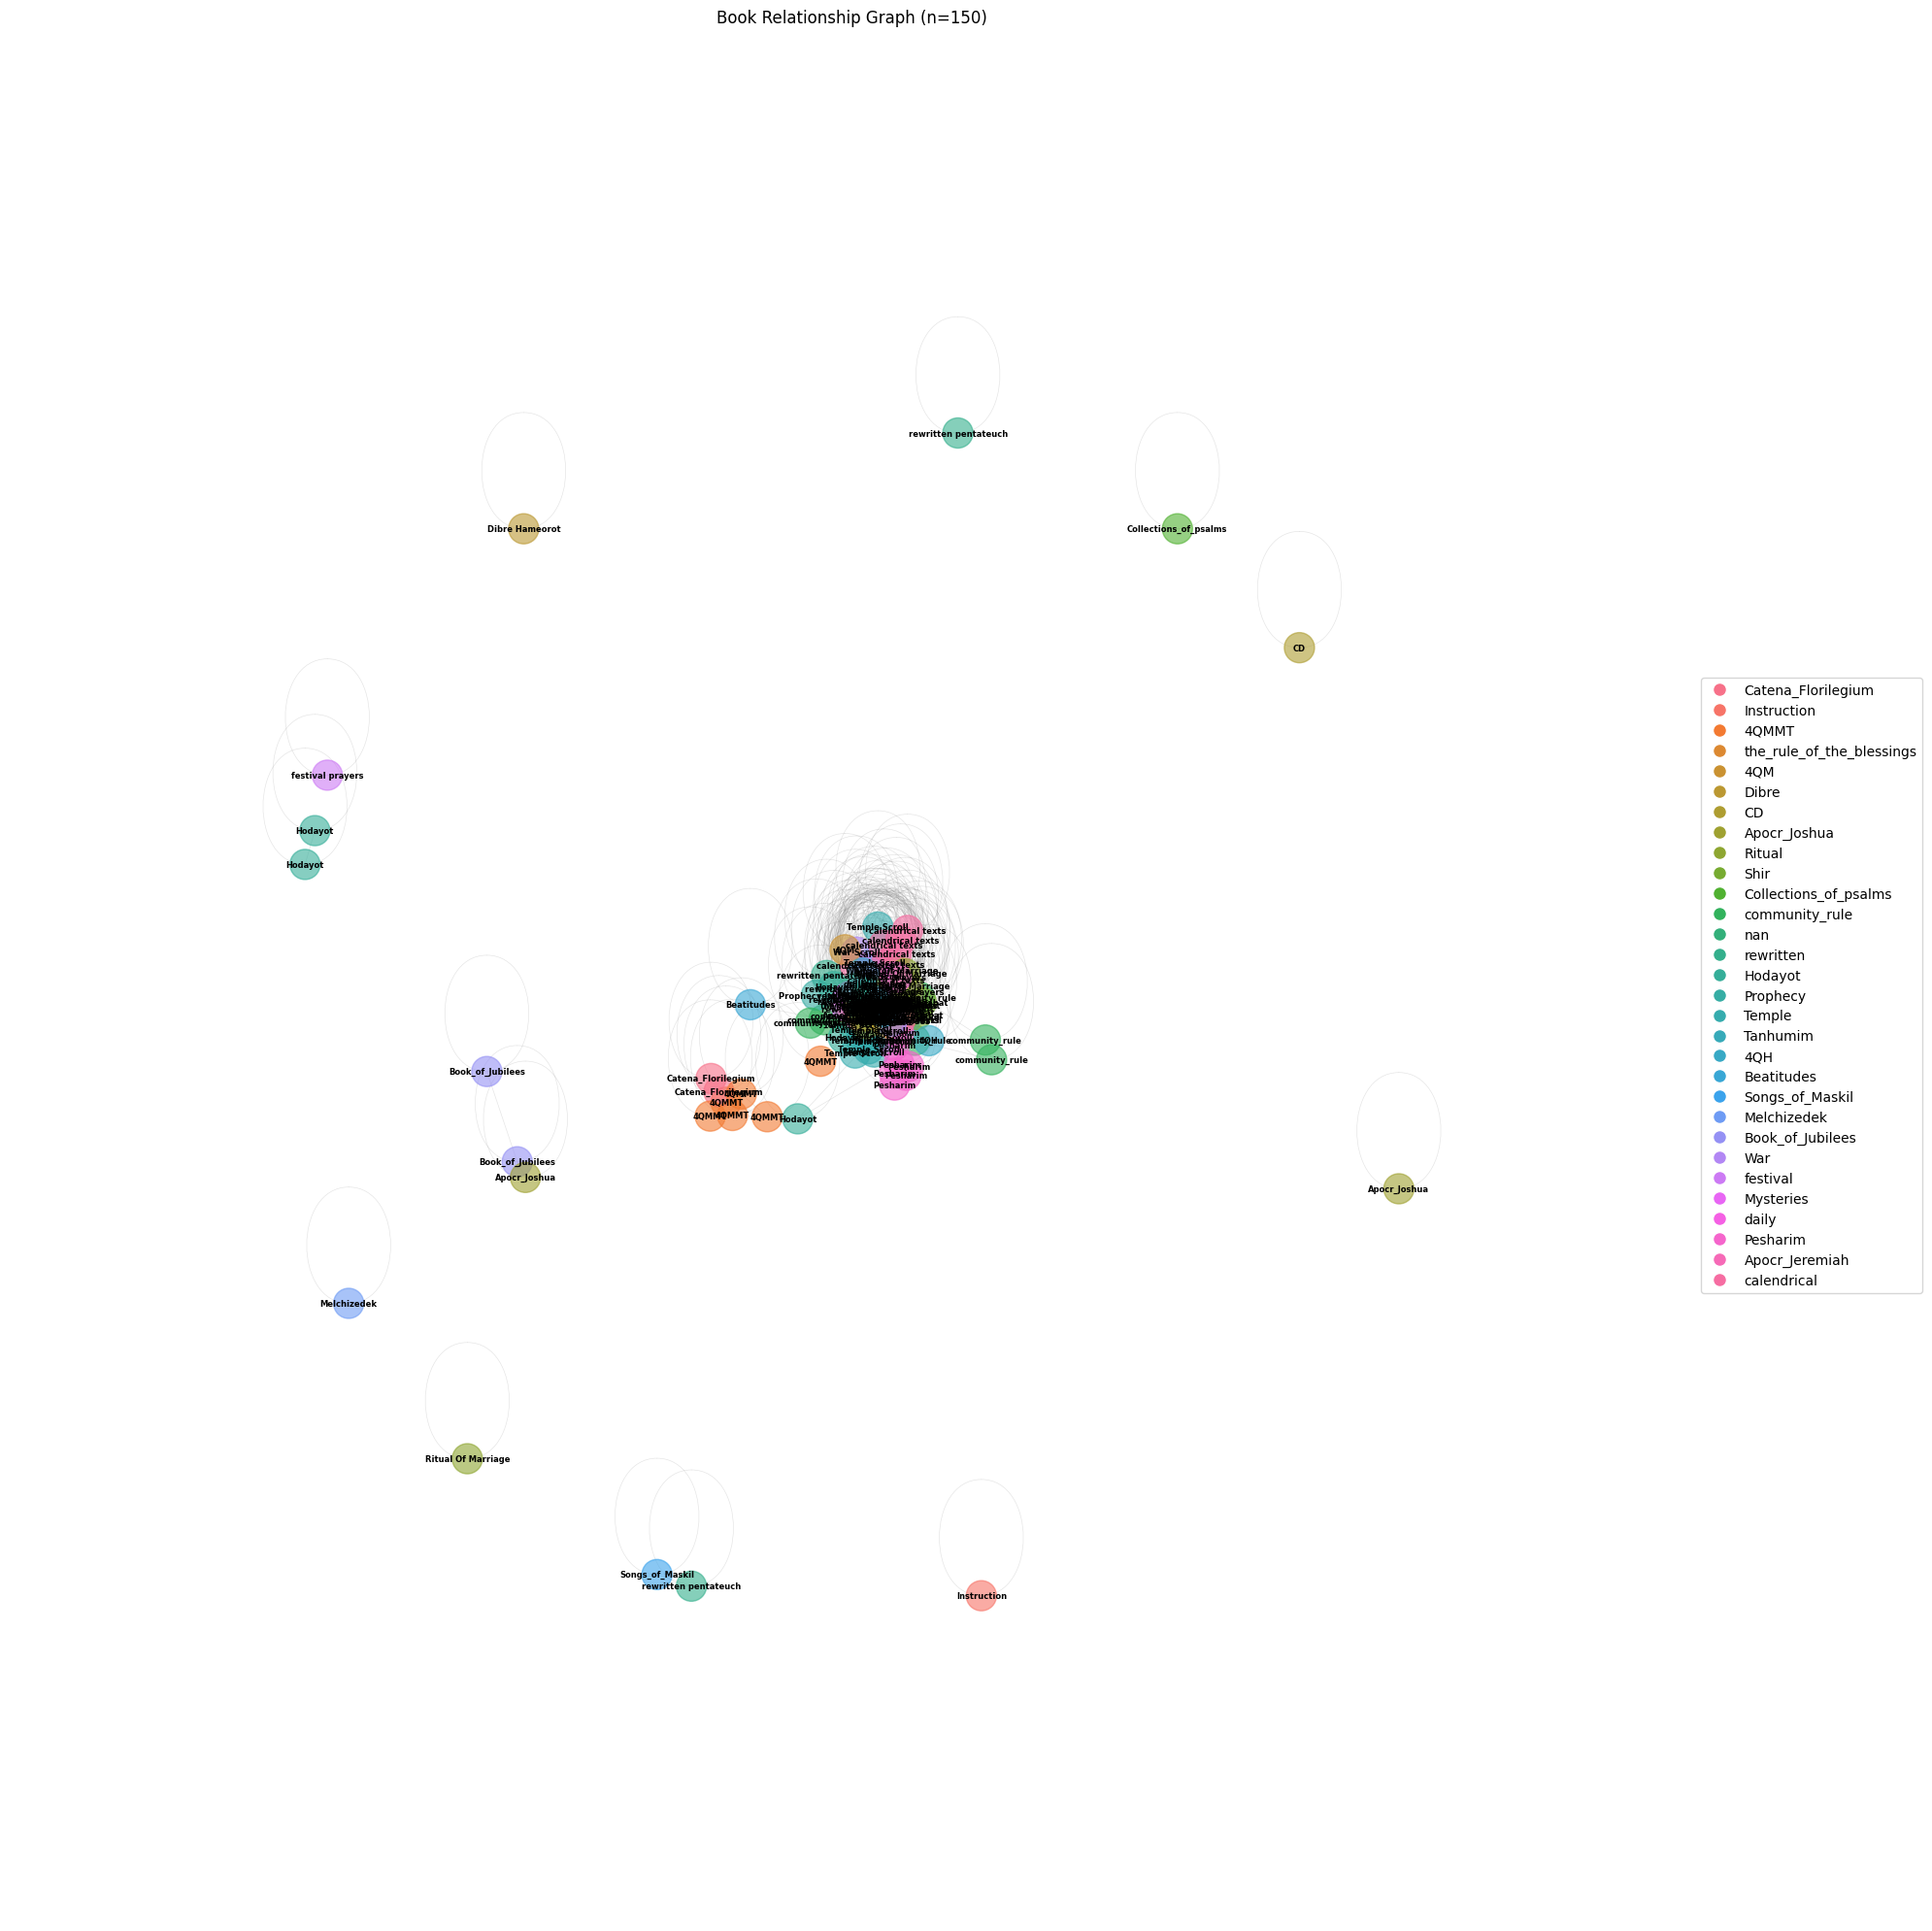

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import rgb2hex
import seaborn as sns

def plot_book_graph(adj_matrix, df, label, n=None):
    """
    Plot a graph from an adjacency matrix using book names as labels,
    with nodes colored based on their labels.
    
    Parameters:
    -----------
    adj_matrix : numpy.ndarray
        The adjacency matrix representing the graph
    df : pandas.DataFrame
        DataFrame containing 'book' and 'sentence_path' columns
    n : int, optional
        Number of nodes to randomly sample. If None, use all nodes.
    """
    if n is not None and n < len(df):
        idxs = np.random.choice(len(df), n, replace=False)
        sampled_adj_matrix = adj_matrix[np.ix_(idxs, idxs)]
        sampled_df = df.iloc[idxs].reset_index(drop=True)
    else:
        sampled_adj_matrix = adj_matrix
        sampled_df = df
    
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(sampled_adj_matrix)
    
    # Create a mapping of node indices to book names
    labels = {i: book for i, book in enumerate(sampled_df[label])}
    
    # Get unique categories from book names (e.g., first word or specific pattern)
    # You might want to customize this based on your actual book naming pattern
    categories = [str(book).split()[0] for book in sampled_df[label]]
    unique_categories = list(set(categories))
    
    # Create a color palette
    n_colors = len(unique_categories)
    color_palette = sns.color_palette("husl", n_colors)
    color_dict = dict(zip(unique_categories, color_palette))
    
    # Assign colors to nodes based on their categories
    node_colors = [color_dict[categories[i]] for i in range(len(categories))]
    
    # Set up the plot
    plt.figure(figsize=(20, 20))
    
    # Use spring layout with adjusted parameters
    # pos = nx.spring_layout(G, k=1.5, iterations=50)
    pos = nx.kamada_kawai_layout(G)
    
    # Draw the network
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_colors,
                          node_size=500,
                          alpha=0.6)
    
    nx.draw_networkx_edges(G, pos,
                          edge_color='gray',
                          alpha=0.2,
                          width=0.5)
    
    # Add labels
    nx.draw_networkx_labels(G, pos, labels,
                           font_size=6,
                           font_weight='bold')
    
    # Create legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color_dict[cat], 
                                 label=cat, markersize=10)
                      for cat in unique_categories]
    plt.legend(handles=legend_elements, 
              loc='center left', 
              bbox_to_anchor=(1, 0.5))
    
    # Remove axes
    plt.axis('off')
    
    # Add title
    plt.title(f"Book Relationship Graph (n={len(sampled_df)})", pad=20)
    
    # Add more margin around the plot
    plt.margins(0.2)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:

n = 150
plot_book_graph(adj_matrix, df, "composition",n=n)


In [29]:
import plotly.graph_objects as go
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

def remove_isolated_nodes(adj_matrix, df):
    """
    Remove nodes that have no connections (all zeros in adjacency matrix)
    
    Parameters:
    -----------
    adj_matrix : numpy.ndarray
        The adjacency matrix representing the graph
    df : pandas.DataFrame
        DataFrame containing 'book' and 'sentence_path' columns
        
    Returns:
    --------
    filtered_adj_matrix : numpy.ndarray
        Adjacency matrix with isolated nodes removed
    filtered_df : pandas.DataFrame
        DataFrame with isolated nodes removed
    """
    # Find nodes that have at least one connection
    # Sum rows and columns to check for any connections
    connected_nodes = ((adj_matrix.sum(axis=0) + adj_matrix.sum(axis=1)) > 0)
    
    # Get indices of connected nodes
    connected_indices = np.where(connected_nodes)[0]
    
    # Filter adjacency matrix and dataframe
    filtered_adj_matrix = adj_matrix[np.ix_(connected_indices, connected_indices)]
    filtered_df = df.iloc[connected_indices].reset_index(drop=True)
    
    return filtered_adj_matrix, filtered_df


def plot_interactive_graph(adj_matrix, df, label, n=None):
    """
    Create an interactive graph visualization using Plotly.
    
    Parameters:
    -----------
    adj_matrix : numpy.ndarray
        The adjacency matrix representing the graph
    df : pandas.DataFrame
        DataFrame containing 'book' and 'sentence_path' columns
    n : int, optional
        Number of nodes to randomly sample. If None, use all nodes.
    """
    if n is not None and n < len(df):
        idxs = np.random.choice(len(df), n, replace=False)
        sampled_adj_matrix = adj_matrix[np.ix_(idxs, idxs)]
        sampled_df = df.iloc[idxs].reset_index(drop=True)
    else:
        sampled_adj_matrix = adj_matrix
        sampled_df = df
    
    
    filtered_adj_matrix, filtered_df = remove_isolated_nodes(sampled_adj_matrix, sampled_df)
    # Create network
    G = nx.from_numpy_array(filtered_adj_matrix)
    
    # Get position layout
    # pos = nx.spring_layout(G, k=1.5)
    pos = nx.kamada_kawai_layout(G)
    # Get node positions
    Xn = [pos[k][0] for k in range(len(G))]
    Yn = [pos[k][1] for k in range(len(G))]
    
    # Create color mapping
    categories = [str(book).split()[0] for book in filtered_df[label]]
    unique_categories = list(set(categories))
    color_palette = sns.color_palette("husl", len(unique_categories))
    color_dict = dict(zip(unique_categories, color_palette))
    node_colors = [color_dict[categories[i]] for i in range(len(categories))]
    
    # Convert RGB colors to hex for plotly
    node_colors = ['rgb({}, {}, {})'.format(int(r*255), int(g*255), int(b*255)) 
                   for r, g, b in node_colors]
    
    # Create edges trace
    edge_trace = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        trace = go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines',
            showlegend=False
        )
        edge_trace.append(trace)
    
    # Create nodes trace
    node_trace = go.Scatter(
        x=Xn,
        y=Yn,
        mode='markers+text',
        marker=dict(
            size=20,
            color=node_colors,
            line=dict(width=1, color='#888')
        ),
        text=sampled_df[label],
        hovertext=[f"{label}: {book}" for book in sampled_df[label]],
        hoverinfo='text',
        textfont=dict(size=8),
        showlegend=False
    )
    
    # Create legend traces
    legend_traces = []
    for cat, color in zip(unique_categories, color_palette):
        rgb_color = 'rgb({}, {}, {})'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255))
        trace = go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(size=10, color=rgb_color),
            showlegend=True,
            name=cat
        )
        legend_traces.append(trace)
    
    # Combine all traces
    data = edge_trace + [node_trace] + legend_traces
    
    # Create layout
    layout = go.Layout(
        title=f"Constructed Graph from TF-IDF + trigrams (sampled {len(sampled_df)} chunks)",
        showlegend=True,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        plot_bgcolor='white'
    )
    
    # Create figure
    fig = go.Figure(data=data, layout=layout)
    
    # Update layout for better interactivity
    fig.update_layout(
        dragmode='pan',  # Enable panning
        clickmode='event+select'  # Enable click events
    )
    
    return fig

# Example usage:

n = 500
fig = plot_interactive_graph(adj_matrix, df, "composition", n=n)
fig.show()
fig.write_html("book_graph.html")
